In [1]:
!pip install torch torchaudio torchvision
!pip install numpy
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.3 MB/s eta 0:00:00


In [2]:
import os
import torchaudio
import torch
import torchaudio.functional as F

import matplotlib.pyplot as plt

import numpy as np

## Retrieve music and compute their spectrograms

In [ ]:
!unzip slices.zip -d ./data/

Archive:  slices.zip
  inflating: ./data/slices/slice_1.wav  
  inflating: ./data/slices/slice_10.wav  
  inflating: ./data/slices/slice_11.wav  
  inflating: ./data/slices/slice_12.wav  
  inflating: ./data/slices/slice_13.wav  
  inflating: ./data/slices/slice_14.wav  
  inflating: ./data/slices/slice_15.wav  
  inflating: ./data/slices/slice_16.wav  
  inflating: ./data/slices/slice_17.wav  
  inflating: ./data/slices/slice_18.wav  
  inflating: ./data/slices/slice_19.wav  
  inflating: ./data/slices/slice_2.wav  
  inflating: ./data/slices/slice_20.wav  
  inflating: ./data/slices/slice_21.wav  
  inflating: ./data/slices/slice_22.wav  
  inflating: ./data/slices/slice_23.wav  
  inflating: ./data/slices/slice_24.wav  
  inflating: ./data/slices/slice_25.wav  
  inflating: ./data/slices/slice_26.wav  
  inflating: ./data/slices/slice_27.wav  
  inflating: ./data/slices/slice_28.wav  
  inflating: ./data/slices/slice_29.wav  
  inflating: ./data/slices/slice_3.wav  
  inflating: ./d

In [ ]:
def split_wav(wav, num_splits=2):
    """Split a waveform into `num_splits` equal parts along time axis."""
    c, L = wav.shape
    split_len = L // num_splits
    splits = []
    for i in range(num_splits):
        start = i * split_len
        end = (i + 1) * split_len if i < num_splits - 1 else L
        splits.append(wav[:, start:end])
    return splits

def get_spectrogram(wav):
  # convert to mono
  wav = wav.mean(dim=0, keepdim=True)

  #get spectrogram
  wav_stft = torch.stft(wav, 1024, window=torch.hamming_window(1024), return_complex=True, hop_length=256).abs()
  wav_stft = torch.log1p(wav_stft)

  wav_stft = torch.clamp(wav_stft, min=1e-6) #avoid 0 values

  # normalize
  wav_stft = (wav_stft - wav_stft.min()) / (wav_stft.max() - wav_stft.min() + 1e-6)

  return wav_stft


torch.Size([126, 513, 2584])
torch.Size([113, 513, 2584])
torch.Size([13, 513, 2584])


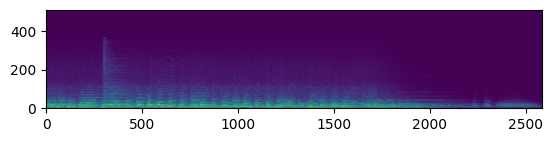

In [ ]:
# get all music
path = 'data/slices/'
files = os.listdir(path)

stfts = []
max_len = 0
for i, fl in enumerate(files):
  wav, fs = torchaudio.load(path + fl)

  for wav_part in split_wav(wav, num_splits=2):

      wav_stft = get_spectrogram(wav_part)

      stfts.append(wav_stft.squeeze())
      if wav_stft.shape[-1] > max_len:
          max_len = wav_stft.shape[-1]


musics = stfts


musics = torch.stack(musics)
print(musics.shape)

cutpt = int(musics.shape[0]*0.9)
musics_tr = musics[:cutpt, :]
musics_test = musics[cutpt:, :]
print(musics_tr.shape)
print(musics_test.shape)


plt.imshow(musics_tr.cpu()[0], origin='lower')


## Defining a CNN to get latent representation of spectrograms

In [6]:
import torch
import torch.nn as nn

class conv_encoder(nn.Module):
    def __init__(self, K=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=K, kernel_size=3, stride=2, padding=1)

        self.convt1 = nn.ConvTranspose2d(in_channels=K, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.convt3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1)

        self.nonl = nn.ReLU()

    def forward(self, x, verbose=False):
        h1 = self.conv1(x)
        h1 = self.nonl(h1)

        h2 = self.conv2(h1)
        h2 = self.nonl(h2)

        h3 = self.conv3(h2)

        h4 = self.convt1(h3)
        h4 = self.nonl(h4)

        h5 = self.convt2(h4)
        h5 = self.nonl(h5)

        xhat = self.convt3(h5)
        if verbose:
          print(h1.shape)
          print(h2.shape)
          print(h3.shape)

          print(h4.shape)
          print(h5.shape)
          print(xhat.shape)
        return xhat, h3


## Model training

In [ ]:
model = conv_encoder(K=32).to('cuda')
model.train()
opt = torch.optim.Adam(params=model.parameters(), lr=1e-4)

eps = 1e-3
batch_size = 4
num_epochs = 2000
N = musics_tr.shape[0]

criterion = nn.MSELoss()

for e in range(num_epochs):
  model.train()

  # shuffle indices
  perm = torch.randint(0, N, (batch_size,))
  total_loss = 0.0

  batch = musics_tr[perm].unsqueeze(1).to("cuda")
  opt.zero_grad()

  out, _ = model.forward(batch)
  H, W = out.shape[-2], out.shape[-1]
  batch = batch[..., :H, :W]

  #using MSE loss
  loss = criterion(out, batch)
  loss.backward()

  opt.step()

  if e % 100 == 0:
    print('ep {} loss val {}'.format(e, loss.item()))


ep 0 loss val 0.021959323436021805
ep 100 loss val 0.007196900900453329
ep 200 loss val 0.002492216881364584
ep 300 loss val 0.002221888629719615
ep 400 loss val 0.0013526176335290074
ep 500 loss val 0.0011639605509117246
ep 600 loss val 0.0013464876683428884
ep 700 loss val 0.0007607058505527675
ep 800 loss val 0.0009306105202995241
ep 900 loss val 0.0008884264971129596
ep 1000 loss val 0.0008540315320715308
ep 1100 loss val 0.0008823583484627306
ep 1200 loss val 0.0005416732165031135
ep 1300 loss val 0.00048309648991562426
ep 1400 loss val 0.0005590036162175238
ep 1500 loss val 0.0007396562141366303
ep 1600 loss val 0.0005997506668791175
ep 1700 loss val 0.000784150674007833
ep 1800 loss val 0.0007174446363933384
ep 1900 loss val 0.0004351958050392568


In [8]:
model.eval()
with torch.no_grad():
    batch = musics_test[:].unsqueeze(1).to("cuda")
    out, _ = model(batch)

    # crop batch to match output
    H, W = out.shape[-2], out.shape[-1]
    batch_cropped = batch[..., :H, :W]

    loss = nn.MSELoss()(out, batch_cropped)
    print("Test batch MSE:", loss.item())

Test batch MSE: 0.0004414792638272047


## UTILISATION DE FAD et MMD



In [ ]:
def compute_covariance(x):
    N = x.shape[0]
    x_centered = x - x.mean(dim=0)
    cov = (x_centered.T @ x_centered) / (N - 1)
    return cov


def compute_FAD(embedding_group1, embedding_group2):

  mu_group1 = embedding_group1.mean(dim=0)
  sigma_group1 = compute_covariance(embedding_group1)

  mu_group2 = embedding_group2.mean(dim=0)
  sigma_group2 = compute_covariance(embedding_group2)

  # Regularisation
  eps = 1e-6
  sigma_group1 += eps * torch.eye(sigma_group1.shape[0]).cuda()
  sigma_group2 += eps * torch.eye(sigma_group2.shape[0]).cuda()

  # FAD
  return F.frechet_distance(mu_group1, sigma_group1, mu_group2, sigma_group2)




def compute_mmd(x, y, sigma=1.0):
    xx = torch.cdist(x, x) ** 2
    yy = torch.cdist(y, y) ** 2
    xy = torch.cdist(x, y) ** 2

    k_xx = torch.exp(-xx / (2 * sigma**2))
    k_yy = torch.exp(-yy / (2 * sigma**2))
    k_xy = torch.exp(-xy / (2 * sigma**2))

    return k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()




In [ ]:
model.eval()

# create 2 audio groups
music_group1 = musics_tr[:10].unsqueeze(0).transpose(0, 1).cuda()  # shape [B, 1, H, W]
music_group2 = musics_test[:10].unsqueeze(0).transpose(0, 1).cuda()

# Get models latents
latents1 = None
latents2= None
with torch.no_grad():
    _, latents1 = model(music_group1)  # latents1 = h3
    _, latents2 = model(music_group2)

print(latents1.shape)
print(latents2.shape)


# average embedding dimensions, does not impact accuracy because FAD and MMD are based on the mean and covariance
embeddings1 = latents1.mean(dim=[2,3])  # shape [B, C]
embeddings2 = latents2.mean(dim=[2,3])

print(embeddings1.shape)
print(embeddings2.shape)

print("FAD score embedding moyenne : ", compute_FAD(embeddings1, embeddings2).item())
print("MMD score embedding moyenne : ", compute_mmd(embeddings1, embeddings2).item())


# The score is low because the groups come from the same video of Pena being cut up, which the model was trained on.
# So, inevitably, the groups are similar
# (fad is a distance; the smaller it is, the more similar it is)


torch.Size([10, 32, 65, 323])
torch.Size([10, 32, 65, 323])
torch.Size([209950, 32])
torch.Size([209950, 32])
FAD score embedding condense :  0.2235884666442871
torch.Size([10, 32])
torch.Size([10, 32])
FAD score embedding moyenne :  0.11046017706394196
MMD score embedding moyenne :  0.08525002002716064
